In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import schemdraw
import schemdraw.elements as elm
sp.init_printing()
%matplotlib inline

A resistor devider is needed to lower the voltage level of the amplifier command voltage used for lab 4 to a lower voltage. The design of this divider must take into account the input impedance of the amplifer.

The circuit we will be analyzing is shown below.

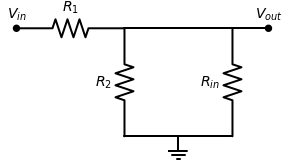

In [2]:
d = schemdraw.Drawing()
d.add(elm.Dot(at=(0, 0), label="$V_{in}$"))
d.add(elm.Resistor(d='r', label="$R_1$"))
d.add(elm.Line(d='r'))
d.add(elm.Resistor(d='d', label="$R_{in}$"))
d.add(elm.Line(d='l', l=1.5))
d.add(elm.Ground())
d.add(elm.Line(d='l', l=1.5))
d.add(elm.Resistor(d='u', label="$R_2$"))
d.add(elm.Line(d='r', at=(6, 0), l=1))
d.add(elm.Dot(label="$V_{out}$"))
d.draw()

In this circuit, the values of one of the resistor is known.

In [3]:
Rin = 100_000 # Ohms

When measured, the input to this voltage divider is:

In [4]:
Vin = 3.1 # Volts

To find $V_{out}$, we begin with the desired current:

In [5]:
Iout = 0.05 # Amps

Since the amplifier gain is:

In [6]:
Ka = 0.06 # A / V

Therefore, the desired voltage is:

In [7]:
Vout = Iout / Ka
print(f"{Vout} Volts")

0.8333333333333334 Volts


Using these values, we can now begin to solve for $R_1$ and $R_2$.

In [8]:
sp.var("R_1 R_2")

The amplifier input impedance ($R_{in}$) and the second resistor of the divider ($R_2$) can be combined together:

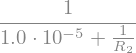

In [9]:
R_2_in = 1 / (1 / R_2 + 1 / Rin)
R_2_in

The equation for the output voltage $V_{out}$ can now be written,

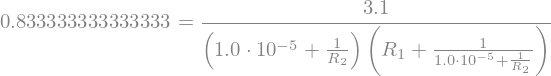

In [10]:
divider = sp.Eq(Vout, Vin * R_2_in / (R_2_in + R_1))
divider

This equation can now be solved for $R_1$.

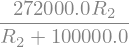

In [11]:
sols = sp.solve(divider, R_1)
assert len(sols) == 1
sol = sols[0]
sol

A function now can be created for finding $R_1$ from $R_2$.

In [12]:
calc_R1 = sp.lambdify(R_2, sol)

The hard part about this design problem is the resistor choices are limited. Resistors are primarily only available in the E-series:

In [13]:
Eseries = np.array([1, 1.2, 1.5, 1.8, 2.2, 2.7, 3.3, 3.9, 4.7, 5.6, 6.8, 8.2])

@np.vectorize
def find_closest(value):
  assert value > 0
  series = np.hstack([Eseries, 10 * Eseries])
  while True:
    if value > series.max():
      series *= 10
    elif value < series.min():
      series /= 10
    else:
      break
  return series[np.abs(series - value).argmin()]
  

We can assume values for R2, then solve for R1.

In [14]:
R2 = np.hstack((1000 * Eseries, 10000 * Eseries))
R2

array([ 1000.,  1200.,  1500.,  1800.,  2200.,  2700.,  3300.,  3900.,
        4700.,  5600.,  6800.,  8200., 10000., 12000., 15000., 18000.,
       22000., 27000., 33000., 39000., 47000., 56000., 68000., 82000.])

We can now solve for the value of the R1, given R2:

In [15]:
R1 = find_closest(calc_R1(R2))
print(R1)

[  2700.   3300.   3900.   4700.   5600.   6800.   8200.  10000.  12000.
  15000.  18000.  22000.  27000.  27000.  33000.  39000.  47000.  56000.
  68000.  82000.  82000. 100000. 120000. 120000.]


In [16]:
calc_V_out = sp.lambdify((R_1, R_2), divider.rhs)

We can now find the output of each divider:

In [17]:
Vout_act = calc_V_out(R1, R2)
Vout_act

array([0.83176818, 0.81945546, 0.85188239, 0.84743189, 0.86076333,
       0.86434797, 0.86911457, 0.84604619, 0.84395273, 0.80970149,
       0.81002152, 0.79427572, 0.78085642, 0.88068182, 0.87818697,
       0.87160262, 0.85959163, 0.8530371 , 0.82874271, 0.79029939,
       0.86964307, 0.81886792, 0.78189911, 0.84620506])

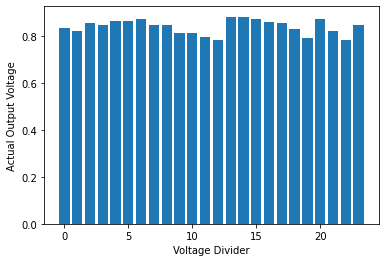

In [18]:
plt.bar(range(Vout_act.size), Vout_act)
plt.ylabel("Actual Output Voltage")
plt.xlabel("Voltage Divider");

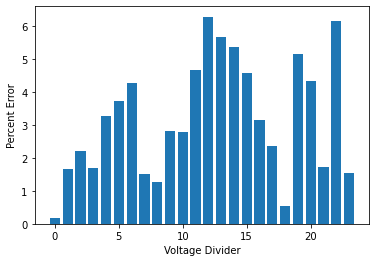

In [19]:
percent_error = 100 * np.abs((Vout_act - Vout) / Vout)
plt.bar(range(percent_error.size), percent_error)
plt.ylabel("Percent Error")
plt.xlabel("Voltage Divider");

The best resistor divider is:

In [20]:
best = percent_error.argmin()
best

0

This resistor divider is composed of resistors with values:

In [21]:
print(f"{R1[best]} and {R2[best]} ohms")

2700.0 and 1000.0 ohms


It results in an output voltage of:

In [22]:
Vout_act[best]

Which has a percent error of:

In [23]:
print(f"{percent_error[best]}%")

0.18781862087471346%


Using these equations, the old amplifier input voltage is estimated at:

In [24]:
print(f"{calc_V_out(22000, 8200)} Volts")

0.7942757155355581 Volts


Which is close to the measured 7.6 Volts